## With OpenLA

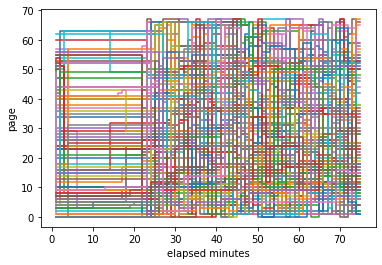

In [1]:
# https://limu.ait.kyushu-u.ac.jp/~openLA/scripts/offtask_detection.html
files_dir = '../../OpenLA/dummy_dataset'

import datetime
import OpenLA as la
from matplotlib import pyplot as plt

course_info, event_stream = la.start_analysis(files_dir=files_dir, course_id="A")

lecture_week = 1
lecture_end_time = course_info.lecture_end_time(lecture_week)
content = course_info.lecture_week_to_contents_id(lecture_week)

behavior = la.convert_into_time_range(course_info, event_stream,
                                      contents_id=content,
                                      lecture_week=lecture_week,
                                      interval_seconds=60,
                                      start_time='start_of_lecture',
                                      end_time=lecture_end_time - datetime.timedelta(minutes=15),
                                      time_range_basis='minutes',
                                      count_operation=False)

ax = la.visualize_pages_in_time_range(behavior,
                                      contents_id=content,
                                      user_id=behavior.user_id())
plt.grid(axis='both', which='both')
plt.show()

## Without OpenLA

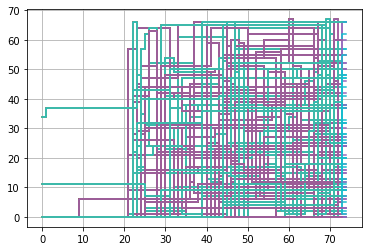

In [2]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as tick
lecture_week = 1
event_stream = pd.read_csv(files_dir + "/Course_A_EventStream.csv")
lecture_schedule = pd.read_csv(files_dir + "/Course_A_LectureTime.csv")
contents_information = pd.read_csv(files_dir + "/Course_A_LectureMaterial.csv")
contents_id = contents_information[contents_information["lecture"] == lecture_week]["contentsid"][0]
lecture_schedule["starttime"] = pd.to_datetime(lecture_schedule["starttime"])
lecture_schedule["endtime"] = pd.to_datetime(lecture_schedule["endtime"])
lecture_start_time = lecture_schedule[lecture_schedule["lecture"] == lecture_week]["starttime"][0]
lecture_end_time = lecture_schedule[lecture_schedule["lecture"] == lecture_week]["endtime"][0]
event_stream["eventtime"] = pd.to_datetime(event_stream["eventtime"])
event_stream = event_stream[event_stream["contentsid"] == contents_id]
event_stream = event_stream[lecture_start_time < event_stream["eventtime"]]
event_stream = event_stream[event_stream["eventtime"] < lecture_end_time - datetime.timedelta(minutes=15)]
prev_page_dict = dict(zip(event_stream["userid"], np.zeros(len(event_stream))))

seconds = [sec for sec in range(0, (lecture_end_time - lecture_start_time - datetime.timedelta(minutes=15)).seconds, 60)]
plt.figure()
max_time_in_figure = 0
max_page_in_figure = 0
for user_id, user_stream in event_stream.groupby('userid'):
    prev_page = 0
    elapsed_minutes_list = []
    pages_list = []
    user_stream.reset_index()
    for sec in seconds:
        start_of_range = lecture_start_time + datetime.timedelta(seconds=sec)
        end_of_range = start_of_range + datetime.timedelta(seconds=60)
        stream_in_range = user_stream[(user_stream['eventtime'] < end_of_range) &
                                      (start_of_range < user_stream['eventtime'])]
        if stream_in_range.empty:
            longest_staying_page = prev_page
        else:
            pages = stream_in_range['pageno']
            event_time = stream_in_range['eventtime']
            staying_time_dict = (dict(zip(pages.unique(), np.zeros(len(pages.unique())))))
            staying_time_dict[prev_page] = (event_time.iat[0] - start_of_range).seconds
            longest_staying_time = (event_time.iat[0] - start_of_range)
            longest_staying_page = prev_page
            for idx, page in enumerate(pages[:-1]):
                if idx + 1 < len(stream_in_range):
                    staying_time = event_time.iat[idx + 1] - event_time.iat[idx]
                else:
                    staying_time = end_of_range - event_time.iat[idx]
                if page == pages.iat[idx + 1]:
                    staying_time_dict[page] += staying_time.seconds
                else:
                    staying_time_dict[pages.iat[idx + 1]] += staying_time.seconds
                if longest_staying_time < staying_time:
                    longest_staying_page = page
            prev_page = longest_staying_page
        elapsed_minutes_list.append(sec/60.0)
        pages_list.append(longest_staying_page)
        plt.step(elapsed_minutes_list, pages_list)
        max_time_in_figure = max(max_time_in_figure, max(elapsed_minutes_list))
        max_page_in_figure = max(max_page_in_figure, max(pages_list))

plt.xlabel = "minutes"
plt.ylabel = "page"
plt.grid(axis='both', which='both')
plt.show()